In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output
import xml.etree.ElementTree as ET
import matplotlib.patches as patches
import cv2

import os
import sys
sys.path.append('/zhome/65/e/156416/E24/IDLCV/Detection_deeplearning_in_computervision')
sys.path.append('/zhome/b6/d/154958/Potholes_boxing/Detection_deeplearning_in_computervision')

from Simple_cnn import train, Simple_CNN
from frednet import PotholeDataset, plot_image_with_bboxes

In [3]:
data_path = '/zhome/b6/d/154958/Potholes_boxing/Detection_deeplearning_in_computervision/Potholes/Potholes/annotated-images'

dataset = PotholeDataset(data_path)
print(f"Loaded {len(dataset)} images with annotations.")
image, annotation = dataset[0]
print("Image shape:", image.shape)
print("Annotation:", annotation)

Loaded 665 images with annotations.
Image shape: (300, 303, 3)
Annotation: {'filename': 'img-621.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-621.jpg', 'size': {'width': 303, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 198, 'ymin': 146, 'xmax': 240, 'ymax': 183}}, {'name': 'pothole', 'bndbox': {'xmin': 7, 'ymin': 44, 'xmax': 114, 'ymax': 117}}, {'name': 'pothole', 'bndbox': {'xmin': 1, 'ymin': 25, 'xmax': 49, 'ymax': 40}}, {'name': 'pothole', 'bndbox': {'xmin': 147, 'ymin': 45, 'xmax': 214, 'ymax': 69}}, {'name': 'pothole', 'bndbox': {'xmin': 224, 'ymin': 65, 'xmax': 287, 'ymax': 87}}, {'name': 'pothole', 'bndbox': {'xmin': 3, 'ymin': 158, 'xmax': 45, 'ymax': 221}}]}


Image shape: (300, 303, 3)
Annotation: {'filename': 'img-621.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-621.jpg', 'size': {'width': 303, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 198, 'ymin': 146, 'xmax': 240, 'ymax': 183}}, {'name': 'pothole', 'bndbox': {'xmin': 7, 'ymin': 44, 'xmax': 114, 'ymax': 117}}, {'name': 'pothole', 'bndbox': {'xmin': 1, 'ymin': 25, 'xmax': 49, 'ymax': 40}}, {'name': 'pothole', 'bndbox': {'xmin': 147, 'ymin': 45, 'xmax': 214, 'ymax': 69}}, {'name': 'pothole', 'bndbox': {'xmin': 224, 'ymin': 65, 'xmax': 287, 'ymax': 87}}, {'name': 'pothole', 'bndbox': {'xmin': 3, 'ymin': 158, 'xmax': 45, 'ymax': 221}}]}


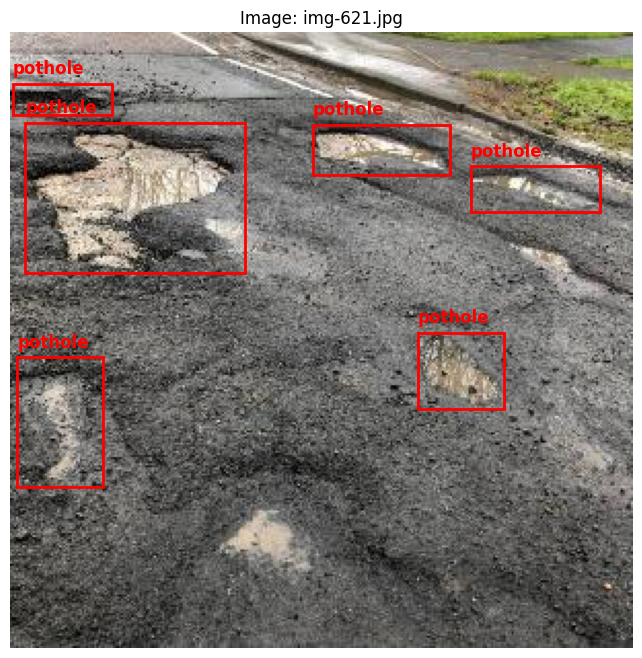

In [4]:
#Plot the first 5 images with their bounding boxes
for idx in range(1):
    image, annotation = dataset[idx]
    print(f"Image shape: {image.shape}")
    print(f"Annotation: {annotation}")
    plot_image_with_bboxes(image, annotation)

In [5]:
import cv2
import numpy as np
import os

def extract_edge_boxes(image, model_path='/zhome/b6/d/154958/Potholes_boxing/Detection_deeplearning_in_computervision/model.yml.gz', max_boxes=100, alpha=0.75, beta=0.75):
    # Load the pre-trained edge detection model
    edge_detection = cv2.ximgproc.createStructuredEdgeDetection(model_path)
    
    # Detect edges and compute orientation map
    edges = edge_detection.detectEdges(np.float32(image) / 255.0)
    orientation_map = edge_detection.computeOrientation(edges)
    
    # Create Edge Boxes object
    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(max_boxes)
    edge_boxes.setAlpha(alpha) # Step size of the sliding window. Typical values range from 0.5 to 0.75.
    edge_boxes.setBeta(beta) #  Non-maximum suppression threshold. Typical values range from 0.6 to 0.9.
    
    # Get bounding boxes
    boxes, scores = edge_boxes.getBoundingBoxes(edges, orientation_map)
    return boxes, scores

Image shape: (300, 303, 3)
Annotation: {'filename': 'img-621.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-621.jpg', 'size': {'width': 303, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 198, 'ymin': 146, 'xmax': 240, 'ymax': 183}}, {'name': 'pothole', 'bndbox': {'xmin': 7, 'ymin': 44, 'xmax': 114, 'ymax': 117}}, {'name': 'pothole', 'bndbox': {'xmin': 1, 'ymin': 25, 'xmax': 49, 'ymax': 40}}, {'name': 'pothole', 'bndbox': {'xmin': 147, 'ymin': 45, 'xmax': 214, 'ymax': 69}}, {'name': 'pothole', 'bndbox': {'xmin': 224, 'ymin': 65, 'xmax': 287, 'ymax': 87}}, {'name': 'pothole', 'bndbox': {'xmin': 3, 'ymin': 158, 'xmax': 45, 'ymax': 221}}]}
Extracted 100 edge boxes


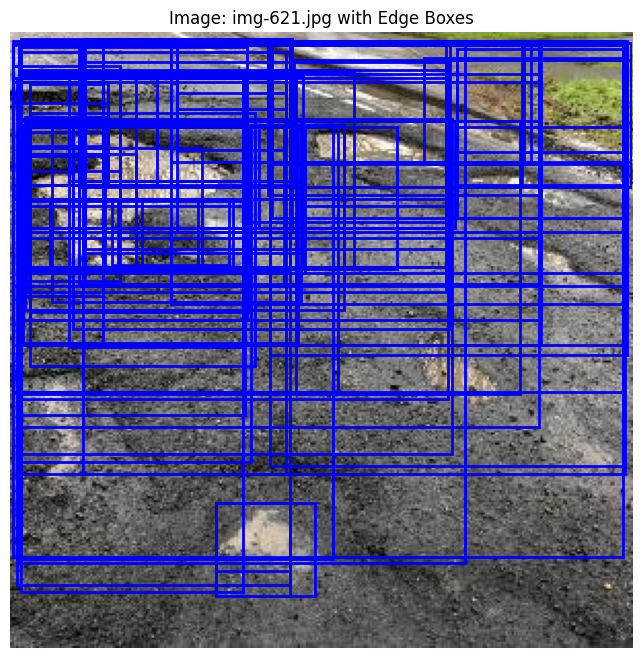

Image shape: (300, 480, 3)
Annotation: {'filename': 'img-577.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-577.jpg', 'size': {'width': 480, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 37, 'ymin': 154, 'xmax': 235, 'ymax': 234}}, {'name': 'pothole', 'bndbox': {'xmin': 104, 'ymin': 120, 'xmax': 141, 'ymax': 132}}, {'name': 'pothole', 'bndbox': {'xmin': 35, 'ymin': 241, 'xmax': 96, 'ymax': 300}}, {'name': 'pothole', 'bndbox': {'xmin': 274, 'ymin': 194, 'xmax': 342, 'ymax': 237}}, {'name': 'pothole', 'bndbox': {'xmin': 313, 'ymin': 242, 'xmax': 354, 'ymax': 283}}, {'name': 'pothole', 'bndbox': {'xmin': 361, 'ymin': 227, 'xmax': 419, 'ymax': 270}}, {'name': 'pothole', 'bndbox': {'xmin': 359, 'ymin': 182, 'xmax': 437, 'ymax': 218}}, {'name': 'pothole', 'bndbox': {'xmin': 366, 'ymin': 146, 'xmax': 479, 'ymax': 189}}, {'name': 'pothole', 'bndbox': {'xmin': 322, 'ymin': 126, 'xmax': 363, 'ymax': 150}}, {'name': 'pothole', 'bndbox': {'xmin': 339, 'ymin'

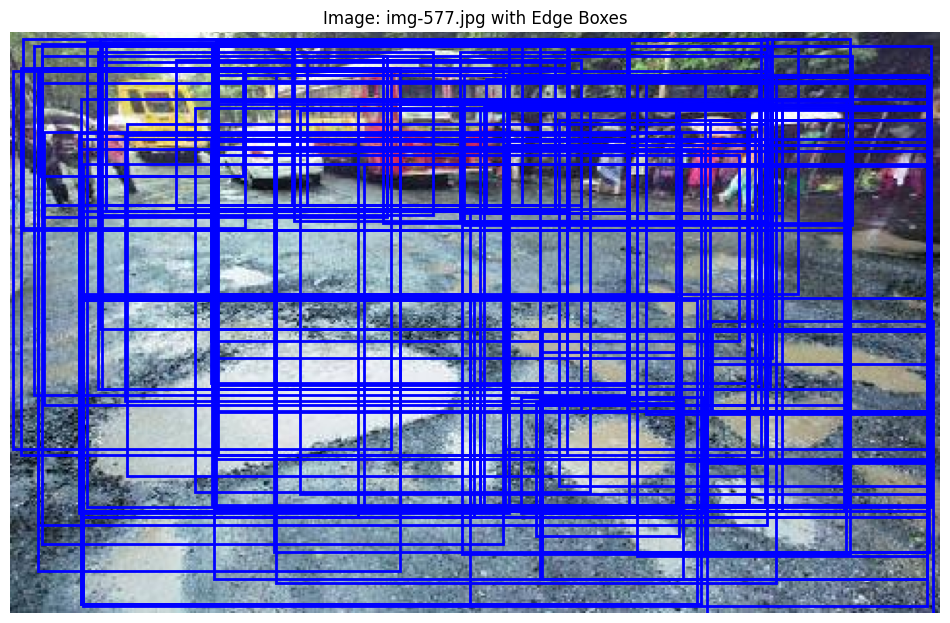

Image shape: (300, 400, 3)
Annotation: {'filename': 'img-338.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-338.jpg', 'size': {'width': 400, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 62, 'ymin': 74, 'xmax': 370, 'ymax': 257}}]}
Extracted 100 edge boxes


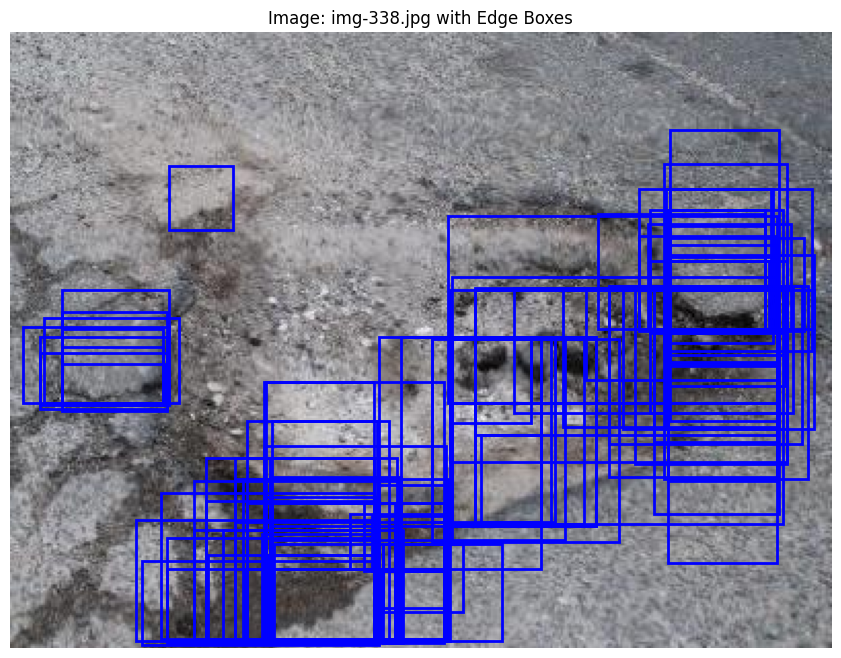

Image shape: (300, 400, 3)
Annotation: {'filename': 'img-561.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-561.jpg', 'size': {'width': 400, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 176, 'ymin': 38, 'xmax': 212, 'ymax': 52}}, {'name': 'pothole', 'bndbox': {'xmin': 190, 'ymin': 5, 'xmax': 247, 'ymax': 25}}, {'name': 'pothole', 'bndbox': {'xmin': 279, 'ymin': 1, 'xmax': 400, 'ymax': 161}}, {'name': 'pothole', 'bndbox': {'xmin': 20, 'ymin': 87, 'xmax': 298, 'ymax': 191}}, {'name': 'pothole', 'bndbox': {'xmin': 61, 'ymin': 201, 'xmax': 179, 'ymax': 300}}, {'name': 'pothole', 'bndbox': {'xmin': 2, 'ymin': 231, 'xmax': 44, 'ymax': 255}}, {'name': 'pothole', 'bndbox': {'xmin': 163, 'ymin': 57, 'xmax': 191, 'ymax': 76}}, {'name': 'pothole', 'bndbox': {'xmin': 124, 'ymin': 70, 'xmax': 160, 'ymax': 87}}, {'name': 'pothole', 'bndbox': {'xmin': 339, 'ymin': 163, 'xmax': 400, 'ymax': 193}}]}
Extracted 100 edge boxes


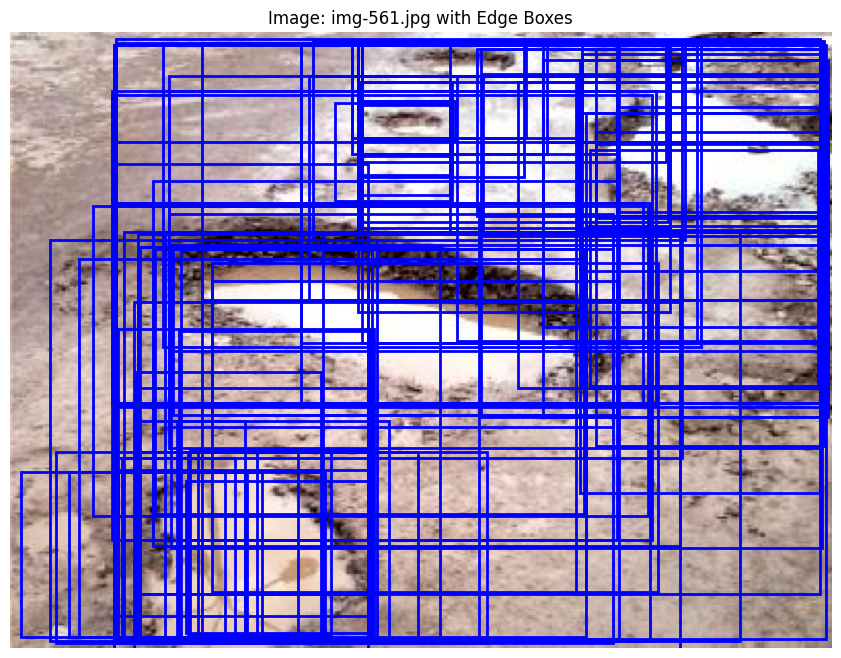

Image shape: (300, 455, 3)
Annotation: {'filename': 'img-455.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-455.jpg', 'size': {'width': 455, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 266, 'ymin': 109, 'xmax': 323, 'ymax': 138}}]}
Extracted 100 edge boxes


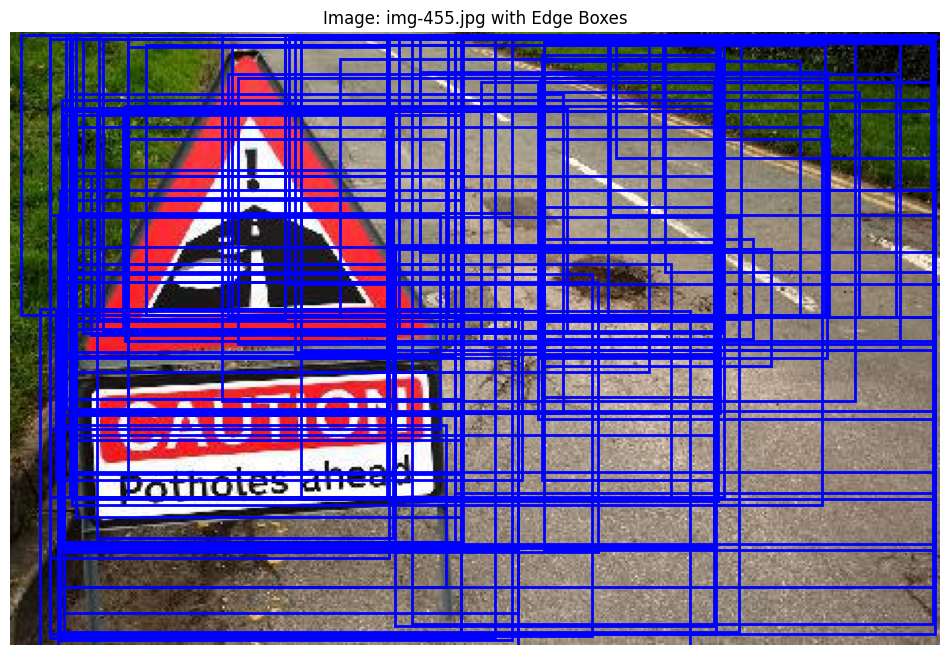

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

for idx in range(5):  # Adjust the range as needed
    image, annotation = dataset[idx]
    print(f"Image shape: {image.shape}")
    print(f"Annotation: {annotation}")

    boxes, scores = extract_edge_boxes(image)
    print(f"Extracted {len(boxes)} edge boxes")

    # Plot image with edge boxes
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for box in boxes:
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(rect)

    plt.title(f"Image: {annotation['filename']} with Edge Boxes")
    plt.axis('off')
    plt.show()

In [6]:
def evaluate_proposals(dataset, iou_threshold, max_images=None):
    successful_proposals = 0
    total_proposals = 0
    if max_images is not None:
        total_images = min(max_images, len(dataset))
    else:
        total_images = len(dataset)
    
    for idx in range(total_images):
        image, annotation = dataset[idx]
        boxes, scores = extract_edge_boxes(image, max_boxes=100)
        
        # Evaluate proposals
        for box in boxes:
            x, y, w, h = box
            found_match = False
            for obj in annotation['objects']:
                if 'bndbox' in obj:
                    gt_x = obj['bndbox']['xmin']
                    gt_y = obj['bndbox']['ymin']
                    gt_w = obj['bndbox']['xmax'] - gt_x
                    gt_h = obj['bndbox']['ymax'] - gt_y
                    
                    # Calculate IoU
                    inter_x1 = max(x, gt_x)
                    inter_y1 = max(y, gt_y)
                    inter_x2 = min(x + w, gt_x + gt_w)
                    inter_y2 = min(y + h, gt_y + gt_h)
                    
                    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
                    union_area = w * h + gt_w * gt_h - inter_area
                    
                    iou = inter_area / union_area
                    
                    if iou >= iou_threshold:
                        found_match = True
                        break
            
            if found_match:
                successful_proposals += 1
            total_proposals += 1
    
    success_rate = successful_proposals / total_proposals if total_proposals > 0 else 0
    return success_rate

# Evaluate proposals on the training set
success_rate = evaluate_proposals(dataset, iou_threshold=0.7, max_images=100)
print(f"Average success rate of proposals: {success_rate:.2%}")


NameError: name 'extract_edge_boxes' is not defined

In [12]:
def prepare_proposals_for_training(dataset, iou_threshold, max_images=None):
    proposals = []
    labels = []
    
    if max_images is not None:
        total_images = min(max_images, len(dataset))
    else:
        total_images = len(dataset)
    
    for idx in range(total_images):
        image, annotation = dataset[idx]
        boxes, scores = extract_edge_boxes(image)
        
        for box in boxes:
            x, y, w, h = box
            proposal_area = w * h
            label = 'background'
            
            for obj in annotation['objects']:
                if 'bndbox' in obj:
                    gt_x = obj['bndbox']['xmin']
                    gt_y = obj['bndbox']['ymin']
                    gt_w = obj['bndbox']['xmax'] - gt_x
                    gt_h = obj['bndbox']['ymax'] - gt_y
                    gt_area = gt_w * gt_h
                    
                    # Calculate IoU
                    inter_x1 = max(x, gt_x)
                    inter_y1 = max(y, gt_y)
                    inter_x2 = min(x + w, gt_x + gt_w)
                    inter_y2 = min(y + h, gt_y + gt_h)
                    
                    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
                    union_area = proposal_area + gt_area - inter_area
                    
                    iou = inter_area / union_area
                    
                    if iou >= iou_threshold:
                        label = obj['name']
                        break
            
            proposals.append(box)
            labels.append(label)
    
    return proposals, labels

# # Prepare proposals for training
# proposals, labels = prepare_proposals_for_training(dataset, iou_threshold=0.7, max_images=10000)
# print(f"Proposals: {proposals}")
# print(f"Labels: {labels}")

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2

class ProposalDataset(Dataset):
    def __init__(self, images, proposals, labels, transform=None):
        """
        Dataset for object detection proposals.
        
        Parameters:
            images (list of str): Paths to the original images.
            proposals (list of list): List of bounding box proposals for each image.
            labels (list of list): List of labels (0 or 1) for each proposal in each image.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = images
        self.proposals = proposals
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # Total number of proposals across all images
        return sum(len(p) for p in self.proposals)

    def __getitem__(self, idx):
        # Locate the image and proposal for the current idx
        cumulative_index = 0
        for i, proposal_boxes in enumerate(self.proposals):
            num_proposals = len(proposal_boxes)
            if cumulative_index + num_proposals > idx:
                proposal_idx = idx - cumulative_index
                image_path = self.images[i]
                proposal_box = proposal_boxes[proposal_idx]
                label = self.labels[i][proposal_idx]
                break
            cumulative_index += num_proposals

        # Load image and crop proposal region
        image = cv2.imread(image_path)
        x, y, w, h = proposal_box
        cropped_image = image[y:y + h, x:x + w]

        # Apply any transformations
        if self.transform:
            cropped_image = self.transform(cropped_image)

        # Convert image to a tensor and label to the required format
        cropped_image = torch.tensor(cropped_image, dtype=torch.float32).permute(2, 0, 1)  # [C, H, W] format
        label = torch.tensor(label, dtype=torch.long)

        return cropped_image, label

# Usage of the Dataset
image_paths = [data_path + "/" + file for file in os.listdir(data_path) if file.endswith(".jpg")]
iou_threshold = 0.7
max_images = 10

# Step 1: Generate proposals and labels
proposals, labels = prepare_proposals_for_training(dataset, iou_threshold=iou_threshold, max_images=max_images)

# Step 2: Initialize the dataset and data loader
dataset = ProposalDataset(images=image_paths, proposals=proposals, labels=labels, transform=None)
data_loader = DataLoader(dataset, batch_size=20, shuffle=True)

# Example: iterating over the DataLoader
for batch_idx, (images, targets) in enumerate(data_loader):
    print(f"Batch {batch_idx + 1}")
    print("Images:", images.shape)  # Should be [batch_size, 3, H, W]
    print("Targets:", targets)      # Should be [batch_size]
    break  # Just check the first batch


IndexError: list index out of range

In [ ]:

def evaluate_proposals_for_different_box_counts(dataset, iou_threshold, max_images=None, max_box_range=(10, 200, 10)):
    box_counts = range(max_box_range[0], max_box_range[1] + 1, max_box_range[2])
    success_rates = []

    for max_boxes in box_counts:
        def custom_extract_edge_boxes(image, max_boxes=max_boxes):
            return extract_edge_boxes(image, max_boxes=max_boxes)  # Using max_boxes as parameter here
        
        # Modify the evaluate_proposals function to accept custom max_boxes per call
        success_rate = evaluate_proposals(dataset, iou_threshold=iou_threshold, max_images=max_images)
        success_rates.append(success_rate)
    
    # Plot success rate vs. max_boxes
    plt.plot(box_counts, success_rates, marker='o')
    plt.xlabel("Number of Proposals (max_boxes)")
    plt.ylabel("Success Rate")
    plt.title(f"Success Rate vs. Number of Proposals (IoU threshold = {iou_threshold})")
    plt.grid()
    plt.show()

# Example usage with IoU threshold = 0.7 and max_images = 50
evaluate_proposals_for_different_box_counts(dataset, iou_threshold=0.7, max_images=50, max_box_range=(10, 200, 10))


NameError: name 'extract_edge_boxes' is not defined

In [8]:
def visualize_proposals(image, proposals, labels):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    
    for box, label in zip(proposals, labels):
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, label, bbox=dict(facecolor='yellow', alpha=0.5))
    
    plt.show()

# Example usage
image, annotation = dataset[0]
proposals, labels = prepare_proposals_for_training(dataset, iou_threshold=0.3, max_images=1)
visualize_proposals(image, proposals, labels)

NameError: name 'prepare_proposals_for_training' is not defined

In [ ]:
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader,Subset
import os
import random
from sklearn.model_selection import train_test_split


class EdgeBoxDataset(Dataset):
    def __init__(self, image_paths, label_paths=None, transform=None, edgebox_params=None, model_path=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
        self.edgebox_params = edgebox_params if edgebox_params else {'maxBoxes': 100}
        self.edge_box_detector = cv2.ximgproc.createEdgeBoxes(**self.edgebox_params)
        
        # Initialize structured edge detector for orientation map if model path is provided
        if model_path:
            self.edge_detector = cv2.ximgproc.createStructuredEdgeDetection(model_path)
        else:
            self.edge_detector = None
            print("Warning: No model path provided for edge orientation. EdgeBoxes proposals may fail.")

        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Generate Edge Boxes proposals
        edges = cv2.Canny(image, 50, 150).astype(np.float32)
        
        # Generate orientation map using structured edge detection
        orientation_map = self.edge_detector.computeOrientation(edges)
        # Get proposals and scores
        proposals, scores = self.edge_box_detector.getBoundingBoxes(edges, orientation_map)
        
        proposals_tensor = torch.tensor(proposals, dtype=torch.float32).to(self.device)
        scores_tensor = torch.tensor(scores, dtype=torch.float32).to(self.device)


        return proposals_tensor, scores_tensor
    
    def _load_label(self, label_path):
        tree = ET.parse(label_path)
        root = tree.getroot()
        
        boxes = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            
            # Append the box as a dictionary
            boxes.append({
                "name": name,
                "xmin": xmin,
                "ymin": ymin,
                "xmax": xmax,
                "ymax": ymax
            })
        
        return boxes

image_paths = [data_path+"/"+file for file in os.listdir(data_path) if file.endswith(".jpg")]
label_paths = [data_path+"/"+file for file in os.listdir(data_path) if file.endswith(".xml")]


random.seed(42)  # Ensure reproducibility
indices = list(range(len(image_paths)))
random.shuffle(indices)

model_path ="/zhome/b6/d/154958/Potholes_boxing/Detection_deeplearning_in_computervision/model.yml.gz"
#70/15/15 SPLIT
train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

train_dataset = Subset(EdgeBoxDataset(image_paths, label_paths, model_path=model_path), train_idx)
val_dataset = Subset(EdgeBoxDataset(image_paths, label_paths,model_path=model_path), val_idx)
test_dataset = Subset(EdgeBoxDataset(image_paths, label_paths,model_path=model_path), test_idx)


batch_size = 20 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

import torch.nn.functional as F
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct_predictions = 0
    total_samples = 0
    cumulative_loss = 0.0
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss for averaging
        cumulative_loss += loss.item()
        
        # Calculate number of correct predictions
        predicted = output.argmax(dim=1)
        correct_predictions += (predicted == target).sum().item()
        total_samples += target.size(0)
    
    # Calculate average loss and accuracy
    accuracy = correct_predictions / total_samples
    avg_loss = cumulative_loss / len(train_loader)

    return accuracy, avg_loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from tqdm import tqdm
model = Simple_CNN()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_acc = []
train_loss = []
num_epochs = 20
for epoch in range(1, num_epochs + 1):
        t = train(model, device, train_loader, optimizer, epoch)
        train_acc.append(t[0])
        train_loss.append(t[1])
        
        
        

        print(f"Epoch {epoch} Train Accuracy: {100 * sum(train_acc)/len(train_acc):.1f}%")
        
        # Evaluate the model on the validation set
        val_correct = 0
        total_val_samples = 0
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            predicted = output.argmax(1)
            val_correct += (target == predicted).sum().item()
            total_val_samples += target.size(0)

        val_acc = val_correct / total_val_samples
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model
            
        print(f"Epoch {epoch} Validation Accuracy: {100 * val_acc:.1f}%")

0it [02:13, ?it/s]


KeyboardInterrupt: 